In [188]:
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from advertools import url_to_df
from matplotlib.ticker import LinearLocator
BROWSING_HISTORY_JSON = 'data/BrowserHistory.json'
# WORDBAGS_JSON = 'data/WordbagsBuckets.json'
LABELS_JSON = 'data/WordbagsLabels.json'

# Timeseries analysis

We ought to construct a timeseries from the labeled data and later conduct analysis of it.

In the importing and preparation part the data will be transformed into pandas's series datatype with time indexing in epoch time (although displaying it in readable format later) and an range of 0 to 2 as the value. We can associate 2 with learning, 1 with laisure and 0 with miscellaneous. <br>
During the preparation we'll also need to manually label the few lacking sites. Later, using the original dataframe of the browsing history we'll replace the outliers we excluded during pre-clustering preparation and fill the gaps with repetition of the last page visited.

The data will be aggregated into 10 minutes intervals, with every value being set to the most common label occuring in the timespan, making it 6*24 = 144 points per day.

If it comes to the analysis part, I plan to check out for cyclicality in the span of a day and a week with the use of Partial Autocorrelation Function.



In [2]:
labels_df = pd.read_json(open(LABELS_JSON, encoding='utf-8'))

update = pd.DataFrame({'netloc': ['ylilauta.org', 'cytu.be', 'www.postgresqltutorial.com'],
                       'label' : ['Laisure', 'Laisure', 'Learning']})

labels_s = pd.concat([labels_df, update], axis=0, ignore_index=True).set_index('netloc')['label']
labels_s = labels_s.map({'Learning' : 2,
                                   'Laisure' : 1,
                                   'Miscellaneous' : 0})

In [15]:
history_df = pd.json_normalize(json.load(open(BROWSING_HISTORY_JSON, encoding='utf-8')), record_path=['Browser History'])
history_df.drop(history_df[history_df['time_usec'] < 1634601600000000].index, inplace=True)
history_df['time_usec'] = pd.to_datetime(history_df['time_usec'], unit='us')
history_df = history_df.join(url_to_df(history_df['url'])[['netloc']])

history_s = history_df.set_index('time_usec')['netloc'].sort_index(ascending=True)
history_s = history_s[history_s.isin(labels_s.index)]

In [20]:
s1 = history_s.map(labels_s)

In [122]:
span = 10

In [ ]:
s2 = s1.resample(f'{span}min', label='left').apply(lambda x : stats.mode(x)[0] if stats.mode(x)[0] or stats.mode(x)[0]==0  else np.nan)
s2.fillna(method='ffill', inplace=True)


In [154]:
nlags = 50
pcaf_vals = pacf(s2, nlags = nlags-1)

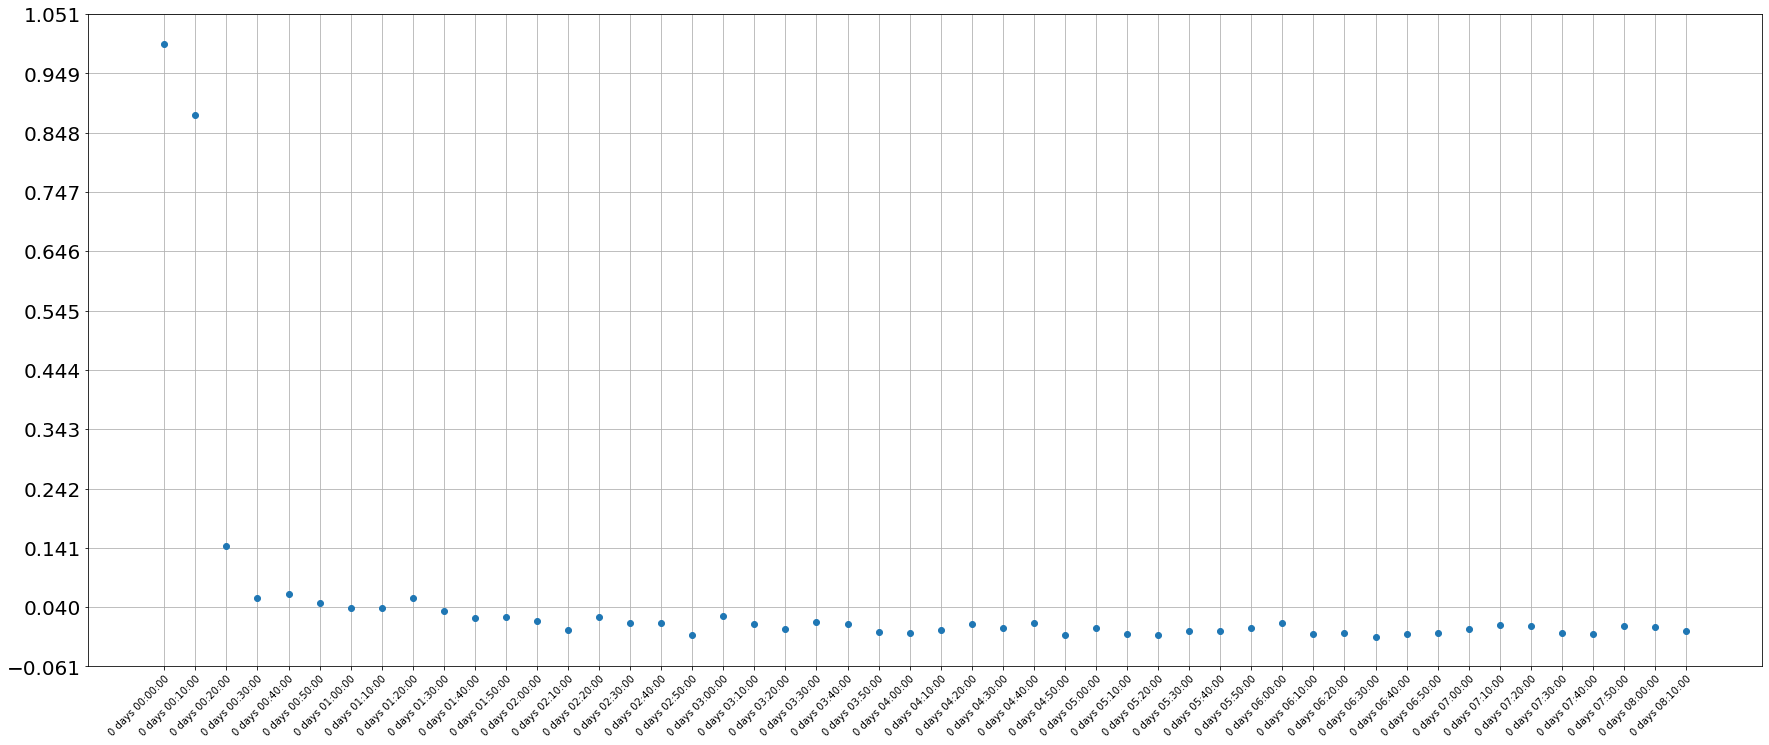

In [192]:

fig, ax1 = plt.subplots(figsize =(30, 12))
ax1.set_xticks(np.arange(nlags))
ax1.set_xticklabels([str(pd.Timedelta(f'{x*span}m')) for x in range(nlags)])
ax1.get_yaxis().set_major_locator(LinearLocator(numticks=12))

ax1.tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=True)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.yticks(fontsize = 20) 

plt.plot(range(nlags), pcaf_vals, linestyle='none', marker='o')
plt.grid()
plt.show()



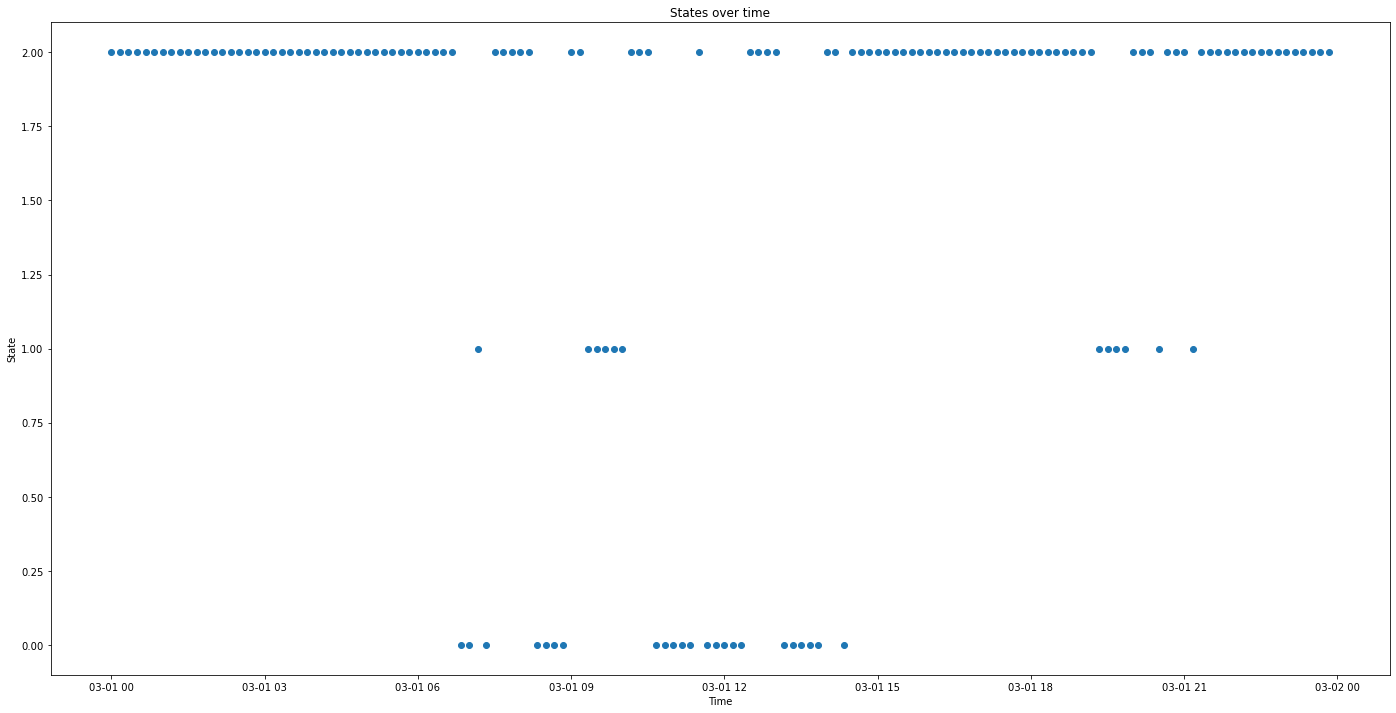

In [109]:
fig, ax = plt.subplots(figsize =(24, 12))
plt.plot(s2['2022-03-01 00:00':'2022-03-01 23:59'], linestyle='none', marker='o')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('States over time')
plt.show()